# Оптимизация производственных расходов

## Описание проекта
Металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали за счет предсказания финальной температуры расплава на начальном этапе. Необходимо по имеющимся данным построить модель, предсказывающую температуру стали ± 6.8°.

## Описание процесса:
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

<img src= "https://cf2.ppt-online.org/files2/slide/n/nm7OEahu2JzxrwVAtb61d8oR3lfYsXZg9PTH0G5U4/slide-8.jpg" alt="Scheme" style="width: 600px;"/>

## Описание данных
Данные состоят из файлов, полученных из разных источников:

`data_arc_new.csv` — данные об электродах;

`data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);

`data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);

`data_gas_new.csv` — данные о продувке сплава газом;

`data_temp_new.csv` — результаты измерения температуры;

`data_wire_new.csv` — данные о проволочных материалах (объём);

`data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План проекта
1. **Загрузка и исследовательский анализ данных**.

Проверка наличия пропусков, аномалий и дубликатов в данных. А также визуализация распределений данных.

2. **Предобработка данных**.

Обработка найденных проблем в каждом из рассматриваемых датасетов и формирование новых признаков.

3. **Формирование признаков**.

Объединение признаков в одну таблицу, выделение тренировочной и тестовой выборок.

4. **Построение и проверка моделей**.

Создание пайплайнов для обучения и кросс-валидации моделей. Планируется использовать три модели: линейную регрессию, случайный лес и градиентный бустинг.

5. **Выбор и испытание лучшей модели**.

Проверка лучшей модели на тестовой выборке. Сравнение её работы с константной моделью. Определение важнейших признаков.

6. **Формирование отчета по проекту**.

Описание проделанной работы и достигнутых результатов.

## 1. Загрузка и исследование данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('dark_background')

In [3]:
RANDOM_STATE = 110923

### 1.1. Данные по электродам.

In [4]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64


In [5]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков нет

In [6]:
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность
count,14876.00,14876.00,14876.00
mean,1615.22,0.66,0.44
std,934.57,0.26,5.87
min,1.00,0.22,-715.48
25%,806.00,0.47,0.34
50%,1617.00,0.60,0.44
75%,2429.00,0.83,0.61
max,3241.00,1.46,1.27


Отрицательная реактивная мощность - аномалия. Учитывая, что медиана по ключам расположена на значении 1617, а максимальное значение 3241, можно ожидать пропущенные партии.

In [7]:
data_arc_new.duplicated().sum()

0

Дубликатов нет

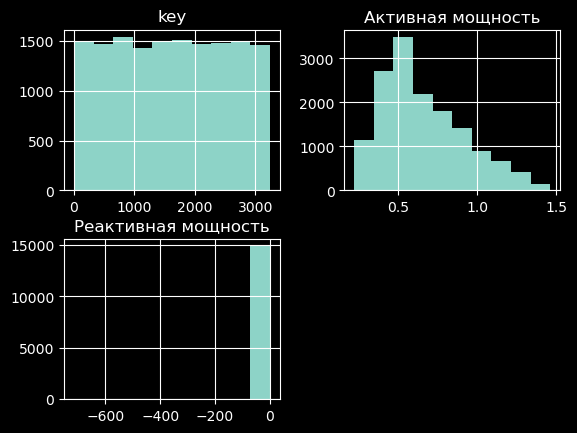

In [8]:
data_arc_new.hist();

#### Вывод
Данные по электродам не содержат пропусков и дубликатов, но имеют аномальные значения реактивной мощности. Распределение по ключам не идеально равномерное, т.е. партии содержат различное количество циклов нагрева.

### 1.2. Данные по сыпучим материалам.

In [9]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00
1,2,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00
2,3,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00
3,4,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00
4,5,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00


Сыпучие материалы, которые не были добавлены в конкретную партию содержат пропуски. Т.е. эти значения эквивалентны нулю.

In [10]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Разные материалы добавляются при обработке с разной частотой. Малоприменимые материалы непригодны для обучения моделей. Например, `Bulk 8` не будет нести информации для модели. 

In [11]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.00,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.00,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,1624.38,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.00,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.00,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.00,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,1622.00,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.00,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,2431.00,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.00,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,3241.00,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.00,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


In [12]:
data_bulk_new.duplicated().sum()

0

Дублей нет

In [13]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Данные по времени внесения сыпучих материалов должны соответствовать соответствующим позициям в таблице с объемами. Пропуски означают, что ввода не производилось.

In [14]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [15]:
data_bulk_time_new.duplicated().sum()

0

Дубликатов нет

#### Вывод
Пропуски в данных соответствуют нулям. Данные по объему сопоставляются с данными по времени внесения. Дубликаты отстутствуют. 

### 1.3. Данные по проволочным материалам.

In [16]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [18]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


In [19]:
data_wire_new.duplicated().sum()

0

In [20]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [22]:
data_wire_time_new.duplicated().sum()

0

#### Вывод
Данные по внесению проволочных материалов аналогичны данным по сыпучим материалам. Только содержат информацию по меньшему количеству партий (3081 против 3129).

### 1.4. Данные по продувочному газу.

In [23]:
data_gas_new.head()

,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


In [24]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [25]:
data_gas_new.describe()

,key,Газ 1
count,3239.00,3239.00
mean,1621.86,11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,1622.00,9.84
75%,2431.50,13.77
max,3241.00,78.00


In [26]:
data_gas_new.duplicated().sum()

0

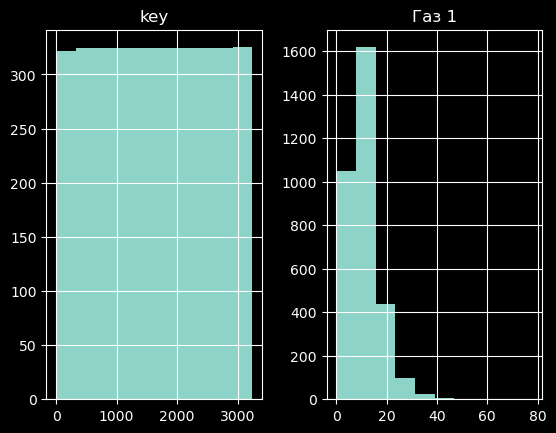

In [27]:
data_gas_new.hist();

#### Вывод
Пропусков и дубликатов в данных по газу нет. Распределение имеет хвост справа, т.е. имеются аномально высокие значения.

### 1.5. Данные по температуре.

In [28]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.00
1,1,2019-05-03 11:07:18,1604.00
2,1,2019-05-03 11:11:34,1618.00
3,1,2019-05-03 11:18:04,1601.00
4,1,2019-05-03 11:25:59,1606.00


In [29]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Столбец с температурой содержит пропуски (~3400 значений) 

In [30]:
data_temp_new.describe()

,key,Температура
count,18092.00,14665.00
mean,1616.46,1590.72
std,934.64,20.39
min,1.00,1191.00
25%,807.75,1580.00
50%,1618.00,1590.00
75%,2429.00,1599.00
max,3241.00,1705.00


Температура расплава стали не может быть ниже 1300°С, т.е. данные по температуре содержат явные аномалии.

In [31]:
data_temp_new.duplicated().sum()

0

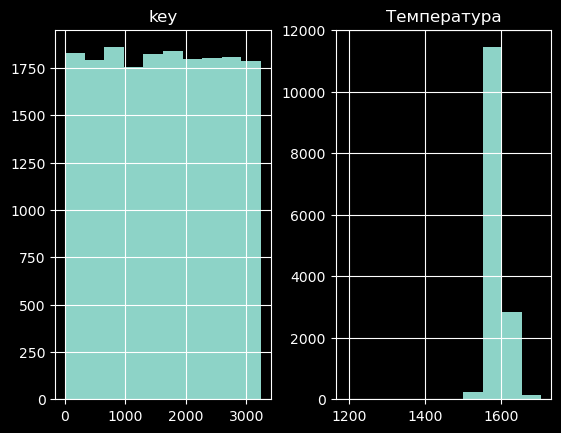

In [32]:
data_temp_new.hist();

#### Вывод
Данные по температуре содержат пропуски и аномалии. Дублей нет. Температура распределена вокруг 1590°С. Значения температуры достигают 1705°С - это поле для оптимизации затрат.

### Вывод
Исследование данных показало, что исходные датасеты содержат пропуски и аномалии. Дубликатов в данных нет.

Основной датасет - данные с температурой. Из него необходимо будет выбрать только начальную и конечную температуры. Партии, содержащие пропуски, аномалии (меньше 1300°С) или единственное значение нужно будет исключить. Также из явных аномалий следует выделить отрицательную реактивную мощность. Эти значения можно восстановить при необходимости. Партии, включающие редкие сыпучие или проволочные материалы (например, `Bulk 8` и `Wire 5`) также следует исключить как нерепрезентативные.

По имеющимся данным можно сгенерировать новые признаки. Из активной мощности и времени можно получить энергию, а потом агрегировать эту энергию по партии. Внесенные материалы можно суммировать по партиям и использовать в качестве признака при обучении модели.

Полученные после предобработки данные необходимо будет соединить по номеру партии. Соответственно, если партия отсутствует в какой-либо из частей объединяемой таблицы, её необходимо исключить.

## 2. Предобработка данных.

### 2.1. Данные по электродам.
Здесь необходимо обработать объекты с отрицательной реактивной мощностью и на основании времени и активной мощности вывести переданную энергию.

In [33]:
data_arc_new[data_arc_new['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.71,-715.48


In [34]:
data_arc_new[(data_arc_new['Активная мощность'] > 0.7) & (data_arc_new['Активная мощность'] < 0.72)]['Реактивная мощность'].median()

0.514625

In [35]:
data_arc_new.loc[9780,'Реактивная мощность'] = data_arc_new[(data_arc_new['Активная мощность'] > 0.7) & (data_arc_new['Активная мощность'] < 0.72)]['Реактивная мощность'].median()

In [36]:
data_arc_new.loc[9780,'Реактивная мощность']

0.514625

In [37]:
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность
count,14876.00,14876.00,14876.00
mean,1615.22,0.66,0.49
std,934.57,0.26,0.20
min,1.00,0.22,0.15
25%,806.00,0.47,0.34
50%,1617.00,0.60,0.44
75%,2429.00,0.83,0.61
max,3241.00,1.46,1.27


In [38]:
data_arc_new['Время работы'] = (pd.to_datetime(data_arc_new['Конец нагрева дугой']) - pd.to_datetime(data_arc_new['Начало нагрева дугой']))

In [39]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время работы
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64,0 days 00:02:28


In [40]:
data_arc_new['Время работы, с'] = data_arc_new['Время работы'].apply(lambda x: x.seconds)

In [41]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время работы,"Время работы, с"
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21,0 days 00:03:48,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48,0 days 00:03:05,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43,0 days 00:02:52,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38,0 days 00:06:05,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64,0 days 00:02:28,148


In [42]:
data_arc_new['energy'] = data_arc_new['Время работы, с'] * data_arc_new['Активная мощность']

In [43]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время работы,"Время работы, с",energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21,0 days 00:03:48,228,69.57
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48,0 days 00:03:05,185,141.65
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43,0 days 00:02:52,172,99.81
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38,0 days 00:06:05,365,189.25
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64,0 days 00:02:28,148,128.34


In [44]:
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность,Время работы,"Время работы, с",energy
count,14876.00,14876.00,14876.00,14876,14876.00,14876.00
mean,1615.22,0.66,0.49,0 days 00:02:51.670946490,171.67,114.04
std,934.57,0.26,0.20,0 days 00:01:38.186802680,98.19,83.01
min,1.00,0.22,0.15,0 days 00:00:11,11.00,5.25
25%,806.00,0.47,0.34,0 days 00:01:47,107.00,57.38
50%,1617.00,0.60,0.44,0 days 00:02:27,147.00,92.19
75%,2429.00,0.83,0.61,0 days 00:03:34,214.00,145.98
max,3241.00,1.46,1.27,0 days 00:15:07,907.00,898.20


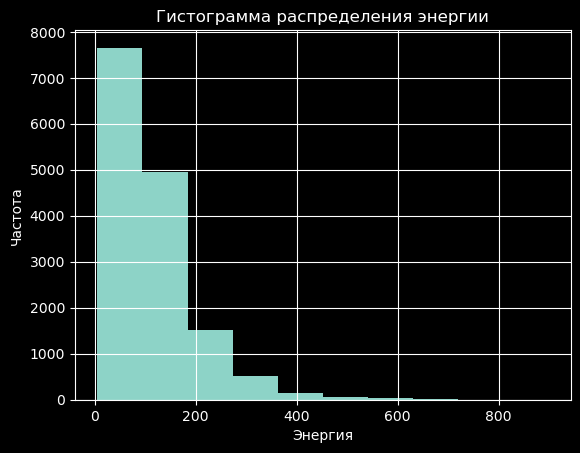

In [45]:
data_arc_new['energy'].hist()
plt.title('Гистограмма распределения энергии')
plt.xlabel('Энергия')
plt.ylabel('Частота');

In [46]:
arc_features = data_arc_new.groupby('key')[['energy', 'Время работы, с']].sum()

In [47]:
arc_features.head()

,energy,"Время работы, с"
key,,
1,628.62,1098
2,395.28,811
3,581.77,655
4,543.71,741
5,412.18,869


In [48]:
arc_features.rename(columns={'Время работы, с': 'duration'}, inplace=True)

In [49]:
arc_features.describe()

,energy,duration
count,3214.00,3214.00
mean,527.85,794.58
std,248.75,332.45
min,26.19,57.00
25%,358.78,571.00
50%,498.86,770.00
75%,669.17,983.00
max,3718.05,4189.00


#### Вывод
Аномалия в реактивной мощности заменена на медианное значение реактивной мощности, полученное на данных в диапазоне 0.70-0.72 активной мощности. Добавлены столбцы с временем работы электродов и переданной энергии. Данные просуммировали по номеру партии.

### 2.2. Данные по сыпучим материалам.
Необходимо заполнить пропуски нулями и удалить столбцы с единичными значениями.

In [50]:
data_bulk_new = data_bulk_new.fillna(0)

In [51]:
data_bulk_new.drop('Bulk 8', axis=1, inplace=True)

In [52]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.00,0.00,0.00,43.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,150.00,154.00
1,2,0.00,0.00,0.00,73.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,149.00,154.00
2,3,0.00,0.00,0.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,205.00,0.00,152.00,153.00
3,4,0.00,0.00,0.00,81.00,0.00,0.00,0.00,0.00,0.00,0.00,207.00,0.00,153.00,154.00
4,5,0.00,0.00,0.00,78.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,0.00,151.00,152.00


In [53]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00
mean,1624.38,3.16,1.78,47.24,33.83,2.63,21.89,2.44,0.46,4.68,4.35,203.95,1.04,152.71,115.32
std,933.34,11.87,21.22,74.24,56.03,20.92,55.49,31.94,6.15,20.16,22.70,151.42,14.11,81.09,84.49
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,816.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,105.00,0.00,104.00,0.00
50%,1622.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,148.00,106.00
75%,2431.00,0.00,0.00,80.00,68.00,0.00,0.00,0.00,0.00,0.00,0.00,263.00,0.00,202.00,204.00
max,3241.00,185.00,325.00,454.00,281.00,603.00,503.00,772.00,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


In [54]:
data_bulk_new.set_index('key', inplace=True)

#### Вывод
Пропуски заполнили нулями, удалили столбец с единственным значением. Номер партии сделали индексом для удобства последующего объединения.

### 2.3. Данные по проволочным материалам.
Необходимо заполнить пропускии удалить столбцы с единичными значениями.

In [55]:
data_wire_new = data_wire_new.fillna(0)

In [56]:
data_wire_new.drop('Wire 5', axis=1, inplace=True)

In [57]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,4,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00


In [58]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00
mean,1623.43,100.04,17.71,3.87,0.26,1.14,0.04,0.33,0.32
std,933.00,42.84,33.52,30.31,4.29,8.96,0.77,4.39,3.81
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,823.00,70.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1619.00,100.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2434.00,125.80,23.16,0.00,0.00,0.00,0.00,0.00,0.00
max,3241.00,330.31,282.78,385.01,113.23,180.45,32.85,102.76,90.05


In [59]:
data_wire_new.set_index('key', inplace=True)

#### Вывод
Заполнили пропускиу, удалили столбец с единственным значением. Номер партии установили в качестве индекса.

### 2.4. Данные по температуре.

In [60]:
missed = data_temp_new[data_temp_new['Температура'].isna()].groupby('key').count().index

In [61]:
data_temp_new = data_temp_new.query('key not in @missed')

In [62]:
too_low = data_temp_new[data_temp_new['Температура'] < 1300].groupby('key').count().index

In [63]:
data_temp_new = data_temp_new.query('key not in @too_low')

In [64]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13905 non-null  int64  
 1   Время замера  13905 non-null  object 
 2   Температура   13905 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB


In [65]:
data_temp_new.describe()

,key,Температура
count,13905.00,13905.00
mean,1243.33,1590.92
std,719.40,18.75
min,1.00,1519.00
25%,623.00,1580.00
50%,1246.00,1590.00
75%,1870.00,1599.00
max,2499.00,1705.00


In [66]:
temp_features = data_temp_new.groupby('key')['Температура'].agg(['first', 'last', 'count'])

In [67]:
temp_features = temp_features[temp_features['count'] > 1]

In [68]:
temp_features.drop('count', axis=1, inplace=True)

In [69]:
temp_features.rename(columns={'first': 'start_temp', 'last': 'end_temp'}, inplace=True)
temp_features.head()

,start_temp,end_temp
key,,
1,1571.00,1613.00
2,1581.00,1602.00
3,1596.00,1599.00
4,1601.00,1625.00
5,1576.00,1602.00


In [70]:
temp_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_temp  2471 non-null   float64
 1   end_temp    2471 non-null   float64
dtypes: float64(2)
memory usage: 57.9 KB


In [71]:
temp_features.describe()

,start_temp,end_temp
count,2471.00,2471.00
mean,1589.01,1595.34
std,25.00,16.04
min,1519.00,1541.00
25%,1572.00,1587.00
50%,1588.00,1593.00
75%,1605.00,1599.00
max,1679.00,1700.00


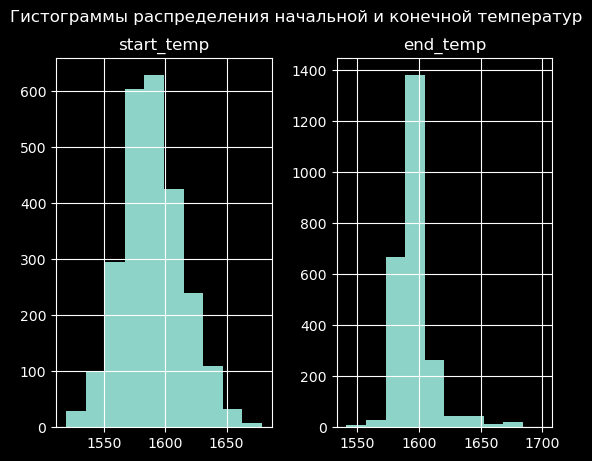

In [72]:
temp_features.hist()
plt.suptitle('Гистограммы распределения начальной и конечной температур');

#### Вывод
Партии, содержащие пропуски, меньше двух значений или аномалии, удалили. Сформировали таблицу из начальной и конечной температуры для каждой партии.

### Вывод
Произвели предобработку данных во всех датафреймах, кроме таблицы с газом (в ней нет проблем).

## 3. Формирование признаков.

### 3.1. Создание единой таблицы признаков.

In [73]:
data = temp_features.merge(data_wire_new, how='inner', on='key')

In [74]:
data.head()

,start_temp,end_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,
1,1571.00,1613.00,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1581.00,1602.00,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1596.00,1599.00,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1601.00,1625.00,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,1576.00,1602.00,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00


In [75]:
data = data.merge(data_bulk_new, how='inner', on='key')
data.head()

,start_temp,end_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,...,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,1571.00,1613.00,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,150.00,154.00
2,1581.00,1602.00,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,149.00,154.00
3,1596.00,1599.00,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,205.00,0.00,152.00,153.00
4,1601.00,1625.00,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,207.00,0.00,153.00,154.00
5,1576.00,1602.00,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,203.00,0.00,151.00,152.00


In [76]:
data = data.merge(arc_features, how='inner', on='key')
data.head()

,start_temp,end_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,...,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,energy,duration
key,,,,,,,,,,,,,,,,,,,,,
1,1571.00,1613.00,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,206.00,0.00,150.00,154.00,628.62,1098
2,1581.00,1602.00,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,206.00,0.00,149.00,154.00,395.28,811
3,1596.00,1599.00,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,205.00,0.00,152.00,153.00,581.77,655
4,1601.00,1625.00,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,207.00,0.00,153.00,154.00,543.71,741
5,1576.00,1602.00,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,203.00,0.00,151.00,152.00,412.18,869


In [77]:
data = data.merge(data_gas_new, how='inner', on='key')

In [78]:
data = data.rename(columns={'Газ 1': 'gas'})

In [79]:
data.set_index('key', inplace=True)

In [80]:
data.head()

,start_temp,end_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,energy,duration,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1571.00,1613.00,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,206.00,0.00,150.00,154.00,628.62,1098,29.75
2,1581.00,1602.00,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,206.00,0.00,149.00,154.00,395.28,811,12.56
3,1596.00,1599.00,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,205.00,0.00,152.00,153.00,581.77,655,28.55
4,1601.00,1625.00,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,207.00,0.00,153.00,154.00,543.71,741,18.84
5,1576.00,1602.00,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,203.00,0.00,151.00,152.00,412.18,869,5.41


In [81]:
data.describe()

,start_temp,end_temp,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,energy,duration,gas
count,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,...,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00
mean,1587.37,1593.37,102.41,17.61,3.24,0.31,0.98,0.01,0.31,0.32,...,0.45,5.06,4.25,208.51,1.07,153.97,120.03,539.27,808.04,11.38
std,23.62,11.21,43.54,33.64,27.97,4.76,8.70,0.21,4.41,3.46,...,6.23,20.93,22.53,157.14,14.25,81.40,84.67,257.30,340.83,6.40
min,1519.00,1541.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.19,57.00,0.01
25%,1571.00,1587.00,73.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,105.00,0.00,105.00,0.00,368.21,581.00,7.28
50%,1587.00,1593.00,101.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,206.00,0.00,149.00,107.00,508.45,778.00,10.10
75%,1603.00,1598.00,128.07,23.10,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,283.00,0.00,204.00,204.00,679.06,993.00,14.22
max,1660.00,1653.00,330.31,282.78,385.01,113.23,180.45,8.49,102.76,62.03,...,147.00,159.00,313.00,1849.00,305.00,636.00,405.00,3718.05,4189.00,78.00


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_temp  2325 non-null   float64
 1   end_temp    2325 non-null   float64
 2   Wire 1      2325 non-null   float64
 3   Wire 2      2325 non-null   float64
 4   Wire 3      2325 non-null   float64
 5   Wire 4      2325 non-null   float64
 6   Wire 6      2325 non-null   float64
 7   Wire 7      2325 non-null   float64
 8   Wire 8      2325 non-null   float64
 9   Wire 9      2325 non-null   float64
 10  Bulk 1      2325 non-null   float64
 11  Bulk 2      2325 non-null   float64
 12  Bulk 3      2325 non-null   float64
 13  Bulk 4      2325 non-null   float64
 14  Bulk 5      2325 non-null   float64
 15  Bulk 6      2325 non-null   float64
 16  Bulk 7      2325 non-null   float64
 17  Bulk 9      2325 non-null   float64
 18  Bulk 10     2325 non-null   float64
 19  Bulk 11     2325 non-null  

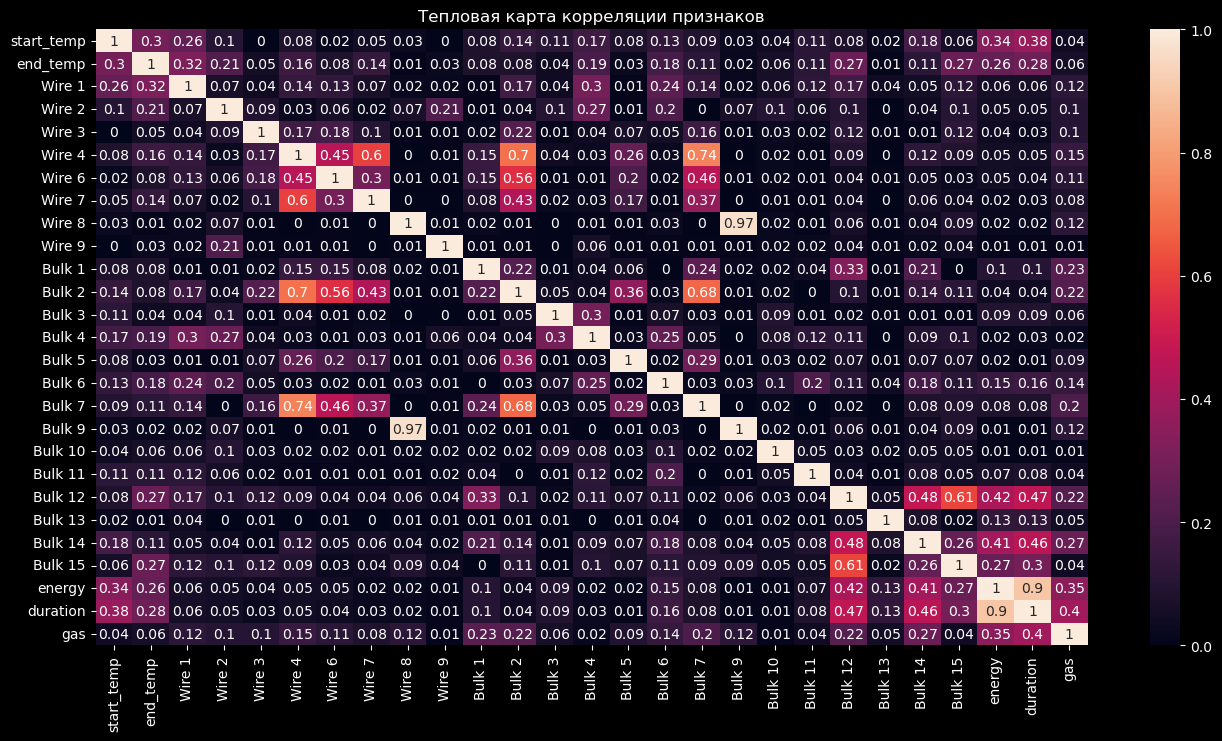

In [83]:
plt.figure(figsize=(16,8))
sns.heatmap(data.corr().abs().round(2), annot=True)
plt.title('Тепловая карта корреляции признаков');

Заметна сильная корреляция между `Bulk 9` и `Wire 8` и между `duration` и `energy`

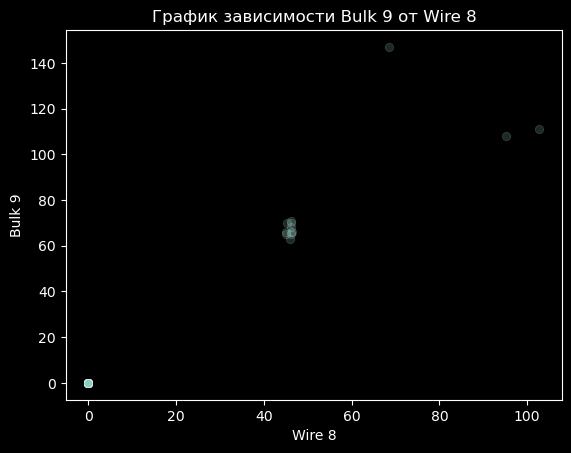

In [84]:
sns.scatterplot(x=data['Wire 8'], y=data['Bulk 9'], alpha=0.2)
plt.title('График зависимости Bulk 9 от Wire 8');

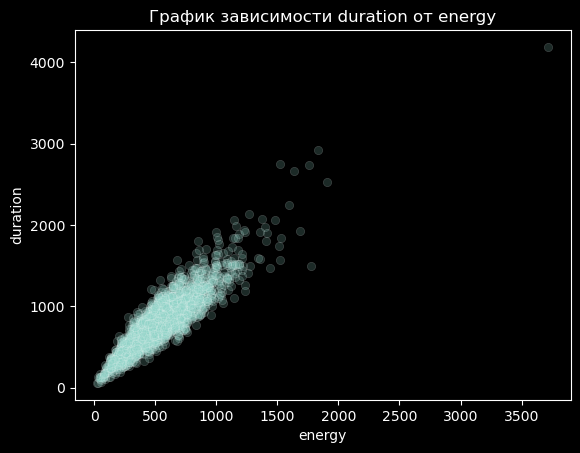

In [85]:
sns.scatterplot(x=data['energy'], y=data['duration'], alpha=0.2)
plt.title('График зависимости duration от energy');

In [86]:
data.drop(['Bulk 9','energy'], axis=1, inplace=True)

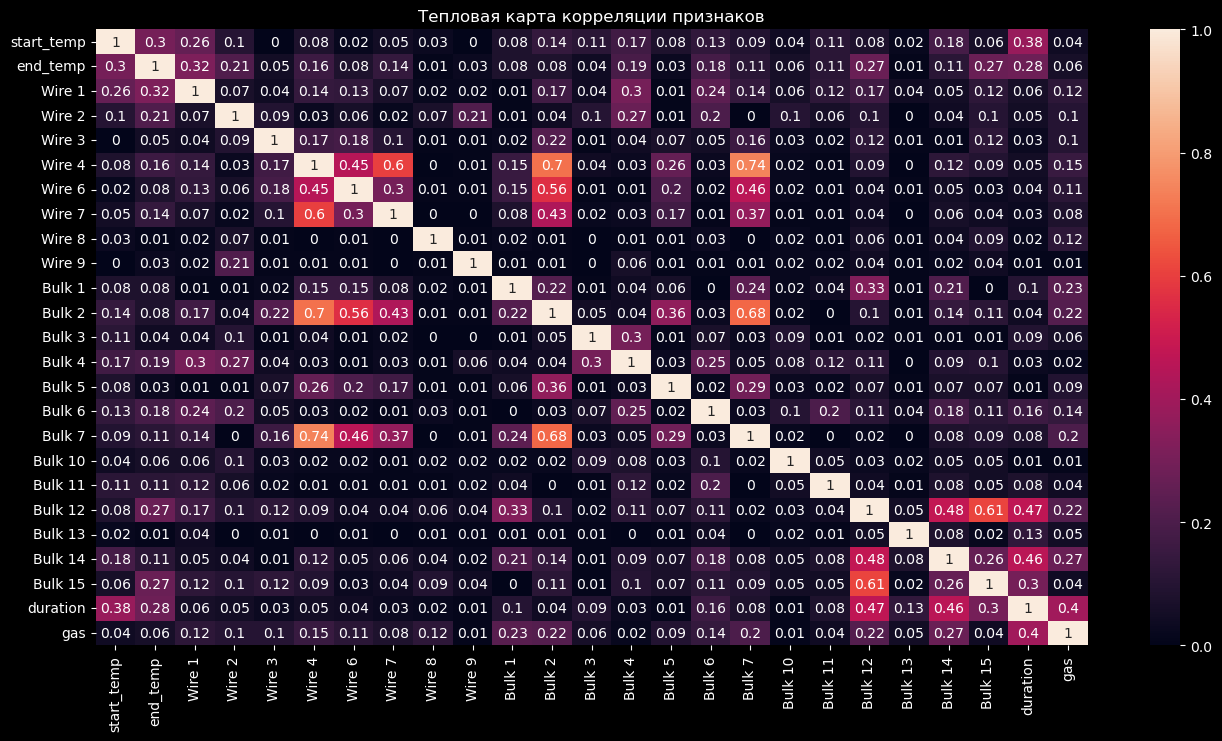

In [87]:
plt.figure(figsize=(16,8))
sns.heatmap(data.corr().abs().round(2), annot=True)
plt.title('Тепловая карта корреляции признаков');

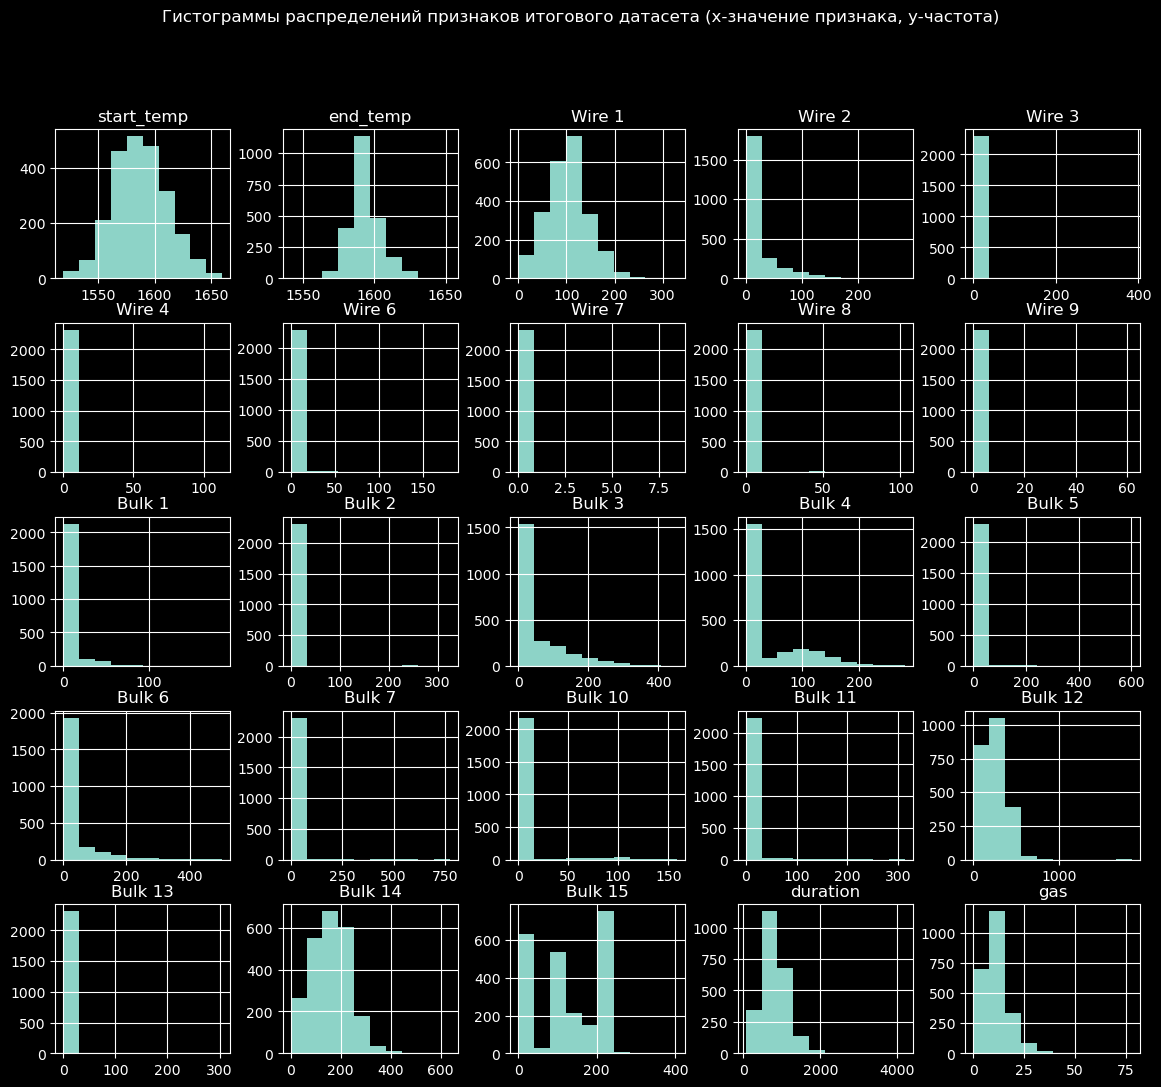

In [88]:
data.hist(figsize=(14,12))
plt.suptitle("Гистограммы распределений признаков итогового датасета (x-значение признака, y-частота)");

#### Вывод
Создали таблицу признаков для обучения моделей. Есть почти прямая корреляция между признаками `Wire 8` и `Bulk 9`. Зависимость видна на граффике рассеяния, хотя большая часть значений сконцентрирована в нуле. Также наблюдается сильная корреляция между `duration` и `energy`. Убрали столбцы `Bulk 9` и `energy` из-за мультиколлинеарности. На графике распределений признаков видно, что большинство вносимых в расплав материалов сосредоточены около нуля.

### 3.2. Разбиение на выборки.

In [89]:
X = data.drop('end_temp', axis=1)
y = data['end_temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1743, 24), (582, 24), (1743,), (582,))

### Вывод
Данные для обучения моделей собраны, произведено разбиение на обучающую и тестовую выборки.

## 4. Обучение и валидация моделей.
Подготовим и проверим три модели машинного обучения: линейную регрессию, случайный лес и градиентный бустинг.

### 4.1. Линейная регрессия.
Для линейной регрессии важен масштаб признаков, поэтому в пайплайн этой модели необходимо добавить масштабирование. Также необходимо учитывать наличие мультиколлинеарности и использовать регуляризацию.

In [90]:
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

lr_space = {'regressor__alpha':list(np.arange(0.5, 15.1, step=0.5))}

lr_random = RandomizedSearchCV(lr_pipe, lr_space, n_iter=14, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2,
                              random_state=RANDOM_STATE)

lr_random.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor', Ridge())]),
                   n_iter=14, n_jobs=-1,
                   param_distributions={'regressor__alpha': [0.5, 1.0, 1.5, 2.0,
                                                             2.5, 3.0, 3.5, 4.0,
                                                             4.5, 5.0, 5.5, 6.0,
                                                             6.5, 7.0, 7.5, 8.0,
                                                             8.5, 9.0, 9.5,
                                                             10.0, 10.5, 11.0,
                                                             11.5, 12.0, 12.5,
                                                             13.0, 13.5, 14.0,
                                                             14.5, 15.0]},
                   random_state=110923, scoring='neg_mean_absolute_error',
 

In [91]:
lr_random.best_params_, -lr_random.best_score_

({'regressor__alpha': 13.5}, 6.217665625820741)

#### Вывод
Модель линейной регрессии показала приемлемый результат на кросс-валидации (МАЕ=6.22).

### 4.2. Случайный лес.

In [92]:
rfr = RandomForestRegressor(random_state=RANDOM_STATE)

rfr_space = {'max_depth':list(np.arange(4, 40, step=5)) + [None],
            'n_estimators':np.arange(100, 501, step=25),
            'min_samples_leaf':np.arange(1, 10, step=1)
          }

rfr_random = RandomizedSearchCV(rfr, rfr_space, n_iter=30, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2,
                              random_state=RANDOM_STATE)

rfr_random.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=110923),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [4, 9, 14, 19, 24, 29, 34,
                                                      39, None],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400,
       425, 450, 475, 500])},
                   random_state=110923, scoring='neg_mean_absolute_error',
                   verbose=2)

In [93]:
rfr_random.best_params_, -rfr_random.best_score_

({'n_estimators': 300, 'min_samples_leaf': 4, 'max_depth': 9},
 6.173355472032482)

#### Вывод
Случайный лес показал результат немного лучше, чем линейная регрессия (МАЕ=6.17)

### 4.3. Градиентный бустинг.

In [94]:
catb = CatBoostRegressor(random_state=RANDOM_STATE)

catb_space = {'depth':list(np.arange(1, 5, step=1)),
              'iterations':np.arange(100, 1000, step=50),
               'learning_rate':np.arange(0.01, 0.3, step=0.03),
              'reg_lambda':np.arange(1, 14, step=2)
}

catb_random = RandomizedSearchCV(catb, catb_space, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2,
                              random_state=RANDOM_STATE)

catb_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0:	learn: 10.8593094	total: 144ms	remaining: 21.5s
1:	learn: 10.6394891	total: 145ms	remaining: 10.8s
2:	learn: 10.4765323	total: 146ms	remaining: 7.17s
3:	learn: 10.2763892	total: 147ms	remaining: 5.38s
4:	learn: 10.1376014	total: 148ms	remaining: 4.3s
5:	learn: 10.0306812	total: 149ms	remaining: 3.59s
6:	learn: 9.9079804	total: 150ms	remaining: 3.07s
7:	learn: 9.7647184	total: 151ms	remaining: 2.69s
8:	learn: 9.6191942	total: 152ms	remaining: 2.39s
9:	learn: 9.5178833	total: 153ms	remaining: 2.15s
10:	learn: 9.4212681	total: 154ms	remaining: 1.95s
11:	learn: 9.3444223	total: 155ms	remaining: 1.78s
12:	learn: 9.2525780	total: 156ms	remaining: 1.65s
13:	learn: 9.1880663	total: 157ms	remaining: 1.53s
14:	learn: 9.1152958	total: 158ms	remaining: 1.43s
15:	learn: 9.0528571	total: 159ms	remaining: 1.33s
16:	learn: 8.9763647	total: 160ms	remaining: 1.25s
17:	learn: 8.9467645	total: 161ms	remaining: 1.18s
18:	learn: 8.9055487	tot

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001CC917C2790>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'depth': [1, 2, 3, 4],
                                        'iterations': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750, 800, 850, 900, 950]),
                                        'learning_rate': array([0.01, 0.04, 0.07, 0.1 , 0.13, 0.16, 0.19, 0.22, 0.25, 0.28]),
                                        'reg_lambda': array([ 1,  3,  5,  7,  9, 11, 13])},
                   random_state=110923, scoring='neg_mean_absolute_error',
                   verbose=2)

In [95]:
catb_random.best_estimator_, -catb_random.best_score_

(<catboost.core.CatBoostRegressor at 0x1cc8b839fa0>, 6.043870921212653)

In [104]:
catb_random.best_estimator_.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 150,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 7,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 110923,
 'depth': 4,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.10000000149011612,
 'score_function

#### Вывод
Результат градиентного бустинга лучше, чем у других моделей (МАЕ=6.04)

### Вывод
Лучшее значение метрики МАЕ на кросс-валидации показала модель градиентного бустинга в реализации CatBoost. Её будем испытывать на тестовой выборке.

## 5. Испытание лучшей модели.

### 5.1. Проверка модели на тестовой выборке.

In [96]:
predictions = catb_random.predict(X_test)
mean_absolute_error(predictions, y_test)

6.561086070448629

#### Вывод
На тестовой выборке модель показазала ошибку 6.56, что ниже предельного значения в 6.8.

### 5.2. Определение важнейших признаков.

In [97]:
feature_importances = pd.DataFrame({'feature_name': X.columns, 'importance': catb_random.best_estimator_.get_feature_importance()})

In [98]:
feature_importances

,feature_name,importance
0,start_temp,26.77
1,Wire 1,5.88
2,Wire 2,4.96
3,Wire 3,0.19
4,Wire 4,0.34
5,Wire 6,0.61
6,Wire 7,0.38
7,Wire 8,0.00
8,Wire 9,0.00
9,Bulk 1,2.24


In [99]:
feature_importances.sort_values(by=['importance'], ascending=False, inplace=True)

In [100]:
feature_importances = feature_importances[feature_importances['importance'] > 5]

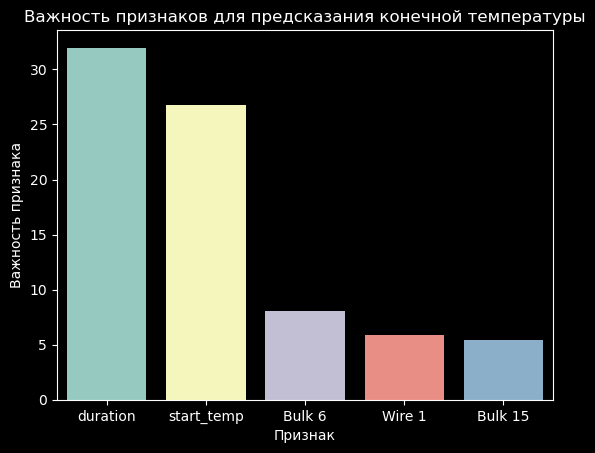

In [101]:
sns.barplot(x=feature_importances['feature_name'], y=feature_importances['importance'])
plt.title('Важность признаков для предсказания конечной температуры')
plt.xlabel('Признак')
plt.ylabel('Важность признака');

#### Вывод
Наиболее информативными признаками для определения конечной температуры являются длительность нагрева и начальная температура.

### 5.3. Сравнение с константной моделью.

In [102]:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
mean_absolute_error(dummy_pred, y_test)

8.207903780068728

#### Вывод
Модель, предсказывающая медианное значение тренировочной выборки, справляется с задачей хуже, чем любая из испытанных моделей.

### Вывод
Модель градиентного бустинга, показавшая лучшие результаты на кросс-валидации, на тестовой выборке показала результата ниже предельного значения. Испытанная модель показывает результат лучше константной модели, выдающей медианное значение тренировочной выборки. Важнейшими признаками для предсказания конечной температуры являются длительность нагрева и начальная температура. 

## Отчет
Исследование проведено в соответствии с изначальным планом. Данные проверены на наличие аномалий, пропусков и дубликатов. Проведена предобработка и формирование новых признаков. Полученные данные сведены в одну таблицу и разбиты на выборки. Тренировочная выборка была использована для обучения и кросс-валидации трёх моделей: линиейной регрессии с L2-регуляризацией, случайного леса и градиентного бустинга в реализации CatBoost. Лучшая модель - градиентный бустинг - была испытана на тестовой выборке. Проведено сравнение лучшей модели с константной и определены важнейшие признаки.

При реализации проекта возникли трудности в виде недостижения требуемого качества при использовании в качестве признака переданной энергии вместо длительности нагрева (один исключали из-за мультиколлинеарности). Длительность нагрева оказалась более информативным признаком для предсказания конечной температуры расплава, хотя это неинтуитивно. В итоговую таблицу признаков взяли именно длительность нагрева.

В исходных данных были обнаружены пропуски и аномалии. Дубликатов не обнаружено. Среди явных аномалии можно выделить отрицательную реактивную мощность на электродах и температуру расплава ниже 1300°С. Пропуски в таблицах с проволочными и сыпучими материалами связаны с отсутствием внесения этих материалов, т.е. это нули. В данных с материалами присутствуют столбцы с одним значением. Они не несут информации для моделей. Пропуски в данных с температурой связаны с неисправностью датчиков. На неисправность датчиков также указывает слишком низкая температура. Партии с такими данными нельзя считать репрезентативными.

Предобработка проводилась отдельно по каждому датасету, кроме датасета с данными по газу (в нем проблем не обнаружено):

1. В данных по электродам было заменено одно отрицательное значение реактивной мощности. Было решено заменить его исходя из данных по активной мощности. В данном случае значение активной мощности было 0.71, соответственно, для замены было выбрано медианное значение реактивной мощности из данных в диапазоне 0.70-0.72 активной мощности. Далее из данных о времени начала и окончания нагрева была получена длительность нагрева. Путем перемножения длительности нагрева и активной мощности получена переданная расплаву энергия. Так как каждая партия включает несколько циклов нагрева, значения просуммированы по партиям.

2. В данных по сыпучим продуктам пропуски были заполнены нулями. Столбец с одним значением (`Bulk 8`) удален.

3. Данные по проволочным матриалам аналогичны сыпучим. Пропуски заполнены нулями. Столбец с одним значением (`Wire 5`) удален.

4. Основной датасет - данные с температурой. Данные отфильтрованы по наличию пропусков и аномалий в значении температуры по партии. Далее проведена агрегация по партии с выделением первого значения (начальная температура), последнего значения (конечная температура) и количества значений в партии. Партии с одним значением убраны из датасета.

Формирование итоговой таблицы признаков производилось путем объединения датасетов по номеру партии, причем партии, не содержащие какой-либо из итоговых признаков, исключались. В итоговой таблице содержатся: номер партии, количественные данные по сыпучим и проволочным материалам, начальная и конечная температуры, переданная энергия, длительность нагрева и количество продувочного газа. Составлена тепловая карта корреляции признаков итогового датасета. Есть почти прямая корреляция между признаками `Wire 8` и `Bulk 9` (0.97) и между `duration` и `energy` (0.90). Исключены `Bulk 9` и `energy`.

Итоговая таблица была разбита на выборки. Целевой признак - конечная температура. Соотношение обучающей и тестовой выборок - 3/1. random_state=110923.

На обучающей выборке проведены обучение и кросс-валидация трех моделей: линиейной регрессии с L2-регуляризацией, случайного леса и градиентного бустинга в реализации CatBoost.

1. Для линейной регрессии был составлен пайплайн со стандартизацией признаков. Кросс-валидация проводилась с помощью RandomizedSearchCV с 5 фолдами с подбором коэффициента регуляризации в диапазоне от 0.5 до 15 с шагом 0.5. Проведено 14 итераций с random_state=110923. В итоге альфа равна 13.5, а итоговое значение МАЕ - 6.22.

2. Модель случайного леса инициализирована с random_state=110923. Пространство настраиваемых гиперпараметров: {'max_depth':list(np.arange(4, 40, step=5)) + [None], 'n_estimators':np.arange(100, 501, step=25), 'min_samples_leaf':np.arange(1, 10, step=1)}. Кросс-валидация проводилась с помощью RandomizedSearchCV с 5 фолдами. Проведено 30 итераций с random_state=110923. Параметры итоговой модели: {'n_estimators': 300, 'min_samples_leaf': 4, 'max_depth': 9}. МАЕ - 6.17.

3. Модель CatBoostRegressor инициализирована с random_state=110923. Пространство настраиваемых гиперпараметров: {'depth':list(np.arange(1, 5, step=1)), 'iterations':np.arange(100, 1000, step=50), 'learning_rate':np.arange(0.01, 0.3, step=0.03), 'reg_lambda':np.arange(1, 14, step=2)}. Параметры итоговой модели: {'depth': 4, 'iterations': 150, 'learning_rate': 0.10000000149011612, 'reg_lambda': 7}. MAE - 6.04 - лучший результат. Приняли эту модель для проверки на тестовой выборке.
          
На тестовой выборке модель градиентного бустинга показала результат МАЕ - 6.56, что соответствует требованиям заказчика (менее 6.8).

Из лучшей модели получена важность признаков для предсказания. Наиболее важными признаками для предсказания конечной температуры расплава являются длительность нагрева и начальная температура расплава.

Проведено сравнение работы итоговой модели с константной моделью, которая выдает медианное значение температуры по тренировочной выборке. Её результат МАЕ - 8.21, что значительно превышает и предельное значение из требований заказчика, и результаты работы финальной модели.

В качестве пространства для улучшения качества модели представляется дальнейшая работа с признаками, их генерация или PCA (если интерпретируемость не важна), а также более тщательный подбор гиперпараметров, например, с помощью Optuna.